In [7]:
"""
Convert building footprints to centroid and sample the image stack
"""

# Packages
import os, time, sys
from os.path import join
import geopandas as gpd
import pandas as pd
import rasterio as rio
import seaborn as sns

from concurrent.futures import ProcessPoolExecutor

# Custom functions
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

print(os.getcwd())

# Coordinate Ref. System
proj = 32618  # UTM Zone 18N

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-rooftop-mapping/'

begin = time.time()  # start time

/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-rooftop-mapping/code


In [2]:
# Load the footprint data
fp = join(maindir, 'data/spatial/mod/dc_data/training/dc_data_reference_centroids.gpkg')
centroids = gpd.read_file(fp)
centroids.head()

,class_code,areaUTMsqft,uid,description,geometry
0,CS,357.783709,1CS,Composition Shingle,POINT (324219.172 4313566.126)
1,CS,918.640862,2CS,Composition Shingle,POINT (324610.477 4311715.754)
2,CS,1383.414170,3CS,Composition Shingle,POINT (327261.743 4300373.479)
3,CS,836.410297,4CS,Composition Shingle,POINT (333611.213 4306261.623)
4,CS,330.514264,5CS,Composition Shingle,POINT (326485.114 4300942.688)


In [3]:
# Load the final image stack
stack_path = join(maindir,'data/spatial/mod/dc_data/planet-data/dc_0623_psscene8b_final_norm.tif')
da_stack = rio.open(stack_path)

# Grab some metadata
desc = list(da_stack.descriptions)
metadata = da_stack.meta
nodata = da_stack.nodata
print(f'Raster description: {desc}; \n Metadata: {metadata}\nNo Data: {nodata}')
if isinstance(da_stack, rio.io.DatasetReader):
    print("The object is a rasterio dataset.")

Raster description: ['nir', 'NDBIbg', 'NDBIrg', 'NISI', 'MNF1', 'NISI9x9', 'NISI27x27']; 
 Metadata: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 6714, 'height': 8223, 'count': 7, 'crs': CRS.from_epsg(32618), 'transform': Affine(3.0, 0.0, 315267.0,
       0.0, -3.0, 4319298.0)}
No Data: None
The object is a rasterio dataset.


In [4]:
band_names = desc
band_names

['nir', 'NDBIbg', 'NDBIrg', 'NISI', 'MNF1', 'NISI9x9', 'NISI27x27']

In [5]:
# Sample all the centroids by roof material type
all_vals = img_vals_at_pts(da_stack,centroids,band_names)

# Check on the results
print(all_vals.head())
print(all_vals['nir'].describe)  # check one column
print(all_vals.columns.values.tolist())

Number of bands to process: 7
0_nir
1_NDBIbg
2_NDBIrg
3_NISI
4_MNF1
5_NISI9x9
6_NISI27x27
   index class_code  areaUTMsqft  uid          description  \
0      0         CS   357.783709  1CS  Composition Shingle   
1      1         CS   918.640862  2CS  Composition Shingle   
2      2         CS  1383.414170  3CS  Composition Shingle   
3      3         CS   836.410297  4CS  Composition Shingle   
4      4         CS   330.514264  5CS  Composition Shingle   

                         geometry       nir    NDBIbg    NDBIrg      NISI  \
0  POINT (324219.172 4313566.126) -0.229591  0.699877  0.654841  0.151559   
1  POINT (324610.477 4311715.754) -0.999411  0.804952  1.277748  1.098665   
2  POINT (327261.743 4300373.479) -0.954901  1.367912  0.859998  0.783161   
3  POINT (333611.213 4306261.623) -0.905333  0.761052  0.991999  0.623787   
4  POINT (326485.114 4300942.688) -0.482489  0.412949  0.807034  0.428988   

       MNF1   NISI9x9  NISI27x27  
0  0.042745  2.427768   0.310636  
1  0

In [6]:
# Write to a gpkg and csv
all_vals = all_vals.to_crs(proj)
all_vals.to_file(join(maindir,'data/spatial/mod/dc_data/training/dc_data_reference_centroid_sampled.gpkg'))
all_vals.drop('geometry',axis=1).to_csv(join(maindir,'data/tabular/mod/dc_data/training/dc_data_reference_centroid_sampled.csv'))

In [13]:
import scipy.stats as stats

# Assuming df is your DataFrame with columns 'class' and 'reflectance_band1'
classes = all_vals['class_code'].unique()

# Perform one-way ANOVA
f_value, p_value = stats.f_oneway(*(all_vals[all_vals['class_code'] == cls]['NISI9x9'] for cls in classes))
f_value_, p_value_ = stats.f_oneway(*(all_vals[all_vals['class_code'] == cls]['NISI27x27'] for cls in classes))

print(f'ANOVA F-value (NISI9x9): {f_value}, p-value: {p_value}\nANOVA F-value (NISI27x27): {f_value_}, p-value: {p_value_}')

ANOVA F-value (NISI9x9): 251.89810717852265, p-value: 4.628e-320
ANOVA F-value (NISI27x27): 156.03582135283284, p-value: 1.13035506352467e-197


### Spectral signature plot

['index' 'class_code' 'areaUTMsqft' 'uid' 'description' 'geometry' 'nir'
 'NDBIbg' 'NDBIrg' 'NISI' 'MNF1' 'NISI9x9' 'NISI27x27']
['Composition Shingle' 'Metal' 'Slate' 'Urethane' 'Tile'
 'Wood shake/shingle' 'Shingle']


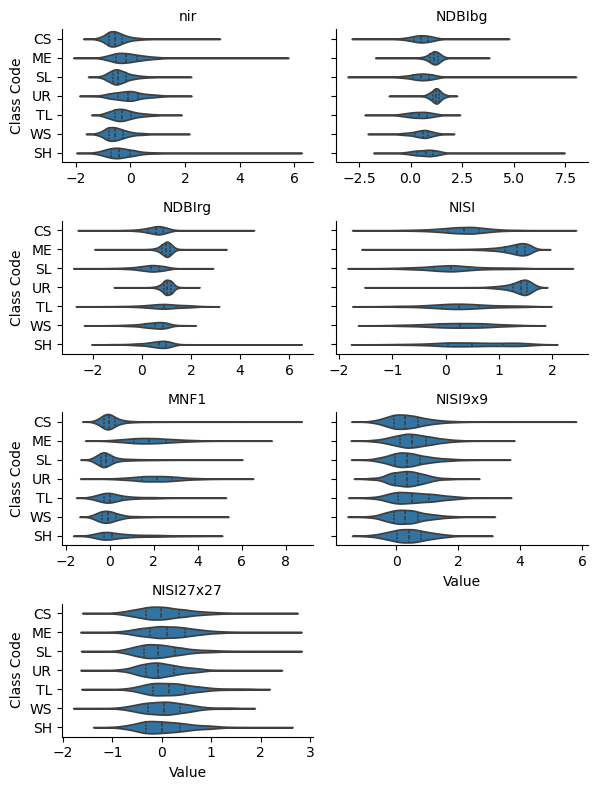

In [15]:
# Plot the distribution of abundances per material type by class
print(all_vals.columns.values)
print(all_vals['description'].unique())

new_cols = ['nir', 'NDBIbg', 'NDBIrg', 'NISI', 'MNF1', 'NISI9x9', 'NISI27x27']

# Melt the DataFrame to long format
all_vals_m = all_vals.melt(
    id_vars=['class_code'],
    value_vars=new_cols,
    var_name='Band',
    value_name='Value')
# Create a facet plot
g = sns.catplot(data=all_vals_m, x='Value', y='class_code', col='Band',
                kind='violin', sharey=True, sharex=False, inner='quartile', 
                col_wrap=2, height=2, aspect=1.5)
# Adjusting the titles and axis labels (if needed)
g.set_titles("{col_name}")
g.set_axis_labels("Value", "Class Code")
# Display the plot
plt.show()